Sensor Component Failure Prediction

1) Problem statement.
Data: Sensor Data

Problem statement :

The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

True class	Positive	Negative	
Predicted class			
Positive	-	cost_1	
Negative	cost_2		
Cost 1 = 10 and Cost 2 = 500

The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost. In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown.

Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.

From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.

Challenges and other objectives
Need to Handle many Null values in almost all columns
No low-latency requirement.
Interpretability is not important.
misclassification leads the unecessary repair costs.

In [55]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
from statistics import mean
from sklearn.preprocessing  import PowerTransformer,LabelEncoder,OneHotEncoder,MinMaxScaler,StandardScaler,RobustScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from catboost import CatBoost ,CatBoostClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
%matplotlib inline



In [6]:
df = pd.read_csv('C://Users//prana//PycharmProjects//Test-Project1//Test-1//aps_failure_training_set1.csv', na_values="na")

In [7]:
df.head(10)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN
5,pos,1056758,0.0,42328.0,856.0,0.0,0.0,0.0,50394.0,184552.0,...,1450086.0,713608.0,1750894.0,4054554.0,4096660.0,2295880.0,220478.0,482.0,0.0,0.0
6,pos,361638,0.0,280.0,NaN,0.0,0.0,0.0,0.0,0.0,...,266410.0,114746.0,180006.0,108294.0,111218.0,264410.0,33734.0,0.0,0.0,0.0
7,pos,791254,NaN,NaN,NaN,NaN,NaN,0.0,14868.0,921256.0,...,3625532.0,1380864.0,3262488.0,5727988.0,7563752.0,12114820.0,264714.0,198.0,NaN,NaN
8,pos,1053152,NaN,NaN,NaN,NaN,NaN,2.0,2.0,30.0,...,7093206.0,3379622.0,7362340.0,8442584.0,8120144.0,5082396.0,6259760.0,176752.0,NaN,NaN
9,pos,785270,NaN,NaN,8994.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [9]:
df.shape

(36188, 171)

In [10]:
df['class'].value_counts()

neg    35188
pos     1000
Name: class, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 47.2+ MB


In [12]:
df.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,3.618800e+04,8292.000000,3.404700e+04,2.698800e+04,34601.000000,34601.000000,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,...,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,34458.000000,34459.000000
mean,6.591016e+04,0.711770,3.535223e+08,3.185447e+05,7.234300,11.606543,1.952347e+02,1.508277e+03,1.250718e+04,1.156928e+05,...,4.853621e+05,2.293208e+05,4.837846e+05,4.401019e+05,3.686943e+05,3.718051e+05,1.485117e+05,8.897664e+03,0.083464,0.209234
std,1.641238e+05,3.054033,7.926486e+08,5.225398e+07,186.437282,234.405353,1.852862e+04,4.371360e+04,1.801543e+05,8.853380e+05,...,1.254188e+06,5.948054e+05,1.251106e+06,1.331837e+06,1.220688e+06,1.722483e+06,5.153265e+05,5.316375e+04,3.789020,8.613915
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.660000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.986000e+03,1.190000e+03,2.732000e+03,3.680000e+03,5.660000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.102600e+04,0.000000,1.520000e+02,1.280000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.378500e+05,1.137840e+05,2.263560e+05,1.952480e+05,9.559400e+04,4.296600e+04,4.278000e+03,0.000000e+00,0.000000,0.000000
75%,5.006850e+04,0.000000,9.640000e+02,4.320000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.470120e+05,2.222860e+05,4.748680e+05,4.103280e+05,2.791920e+05,1.706080e+05,1.432300e+05,2.018000e+03,0.000000,0.000000
max,2.746564e+06,100.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,2.904730e+07,...,3.123272e+07,1.676929e+07,2.747758e+07,5.743524e+07,3.160781e+07,3.727856e+07,1.926740e+07,3.810078e+06,362.000000,1146.000000


In [13]:
df.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [14]:
numeric_features =[feature for feature in df.columns if df[feature].dtype !='object']
categorical_features =[feature for feature in df.columns if df[feature].dtype == 'object']



In [15]:
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

Text(0, 0.5, 'Percentage missing')

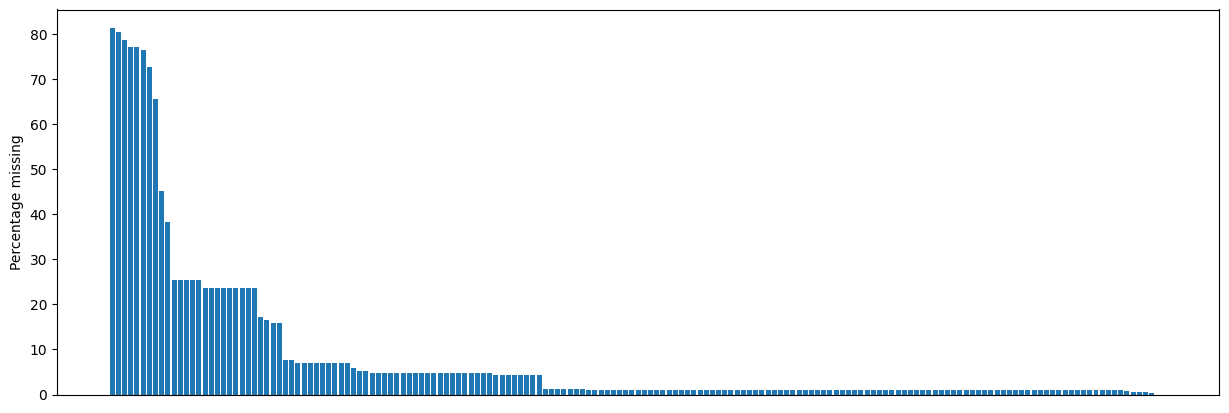

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
ax.bar(missing.index, missing.values.T[0])
ax.set_xticks([])
plt.ylabel("Percentage missing")

In [21]:
df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False)

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
...,...
cj_000,0.560959
ci_000,0.560959
bt_000,0.237648
aa_000,0.000000


In [31]:
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [32]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [33]:
df.shape

(36188, 164)

In [40]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 5.37059852747306%


Positive: 1000, Negative: 35188


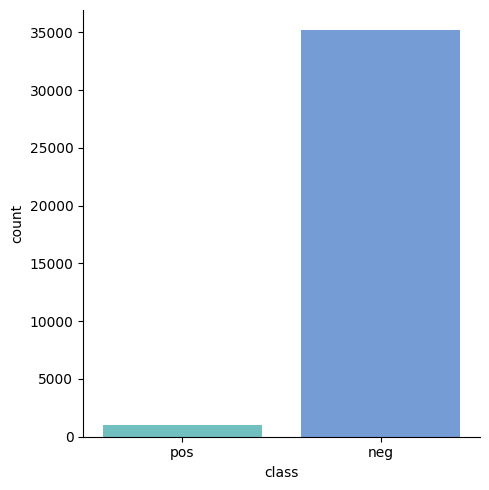

In [41]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)
plt.show()

In [42]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = metrics.accuracy_score(true, predicted) # Calculate Accuracy
    f1 = metrics.f1_score(true, predicted) # Calculate F1-score
    precision = metrics.precision_score(true, predicted) # Calculate Precision
    recall = metrics.recall_score(true, predicted)  # Calculate Recall
    roc_auc = metrics.roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [43]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [44]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')

        report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report


KeyError: 'ab_000'

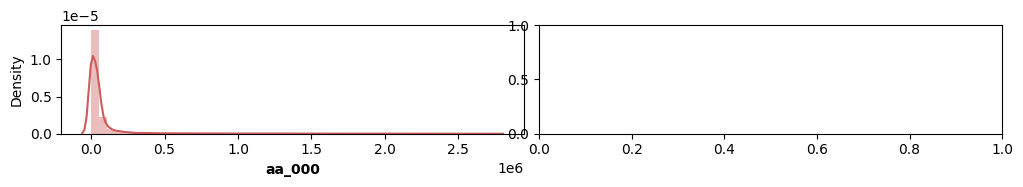

In [47]:
plt.figure(figsize=(15, 100))
for i, col in enumerate(numeric_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [48]:
# Splitting X and y for all Experiments
X= df.drop('class', axis=1)
y = df['class']

In [49]:
# Manually encoding the class output
y= y.replace({'pos': 1, 'neg': 0})

Experiment: 1 = KNN Imputer for Null values


In [50]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)


In [51]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))


n_neighbors= 1 || accuracy (0.7484)
n_neighbors= 3 || accuracy (0.7105)
n_neighbors= 5 || accuracy (0.7207)
n_neighbors= 7 || accuracy (0.7011)
n_neighbors= 9 || accuracy (0.7196)


We can observe n_neighbors=1 able to produce highest accuracy

In [52]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=1)),
    ('RobustScaler', RobustScaler())
])

In [53]:
X_knn =knn_pipeline.fit_transform(X)

In [54]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn, y)

Initialize Default Models in a dictionary


In [56]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

Fit KNN imputed data for models in dictionary


In [57]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 10.
----------------------------------
Model performance for Test set
- Accuracy: 0.9925
- F1 score: 0.9926
- Precision: 0.9886
- Recall: 0.9966
- Roc Auc Score: 0.9925
- COST: 12810.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9852
- F1 score: 0.9853
- Precision: 0.9812
- Recall: 0.9895
- Roc Auc Score: 0.9851
- COST: 38340.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9838
- F1 score: 0.9838
- Precision: 0.9814
- Recall: 0.9862
- Roc Auc Score: 0.9838
- COST: 198730.
----------------------------------
Model performance for Test set
- Accuracy: 0.9820
- F1 score: 0.9822
- Precision: 0.9793
- Recall: 0.9851
- Roc Au

Report for KNN Imputed data


In [58]:
report_knn

,Model Name,Cost
5,XGBClassifier,4470
6,CatBoosting Classifier,7560
0,Random Forest,12810
1,Decision Tree,38340
4,K-Neighbors Classifier,49860
2,Gradient Boosting,53970
7,AdaBoost Classifier,79790
3,Logistic Regression,315490


Experiment: 2 = Simple Imputer with Strategy Median

In [59]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [60]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [61]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [62]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9912
- F1 score: 0.9913
- Precision: 0.9861
- Recall: 0.9966
- Roc Auc Score: 0.9912
- COST: 12990.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9854
- F1 score: 0.9857
- Precision: 0.9796
- Recall: 0.9918
- Roc Auc Score: 0.9854
- COST: 30460.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9840
- F1 score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- Roc Auc Score: 0.9840
- COST: 190760.
----------------------------------
Model performance for Test set
- Accuracy: 0.9810
- F1 score: 0.9812
- Precision: 0.9757
- Recall: 0.9868
- Roc Auc

Report for Simple Imputer with median strategy


In [63]:
report_median

,Model Name,Cost
6,CatBoosting Classifier,5760
5,XGBClassifier,6570
0,Random Forest,12990
1,Decision Tree,30460
2,Gradient Boosting,48240
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,87120
3,Logistic Regression,300120


Experiment: 3 = MICE for Imputing Null values


In [64]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [65]:

X_mice = kernel.complete_data()


In [67]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [68]:
# Fit X with Mice imputer 
X_mice= mice_pipeline.fit_transform(X_mice)

In [69]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [70]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9912
- F1 score: 0.9913
- Precision: 0.9868
- Recall: 0.9959
- Roc Auc Score: 0.9912
- COST: 15440.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9822
- F1 score: 0.9823
- Precision: 0.9780
- Recall: 0.9866
- Roc Auc Score: 0.9822
- COST: 48560.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9854
- F1 score: 0.9854
- Precision: 0.9825
- Recall: 0.9884
- Roc Auc Score: 0.9854
- COST: 166940.
----------------------------------
Model performance for Test set
- Accuracy: 0.9813
- F1 score: 0.9815
- Precision: 0.9772
- Recall: 0.9858
- Roc Auc

Report for MICE Imputer algorithm

In [71]:
report_mice


,Model Name,Cost
5,XGBClassifier,3510
6,CatBoosting Classifier,8190
0,Random Forest,15440
1,Decision Tree,48560
2,Gradient Boosting,51620
4,K-Neighbors Classifier,53150
7,AdaBoost Classifier,93290
3,Logistic Regression,209550


Experiment: 4 = Simple Imputer with Strategy Constant


In [72]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [73]:
X_const =constant_pipeline.fit_transform(X)

In [78]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const, y)

In [79]:
# training the models
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9932
- F1 score: 0.9933
- Precision: 0.9901
- Recall: 0.9964
- Roc Auc Score: 0.9932
- COST: 13200.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9877
- F1 score: 0.9878
- Precision: 0.9826
- Recall: 0.9930
- Roc Auc Score: 0.9877
- COST: 25740.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9829
- F1 score: 0.9829
- Precision: 0.9799
- Recall: 0.9860
- Roc Auc Score: 0.9829
- COST: 201670.
----------------------------------
Model performance for Test set
- Accuracy: 0.9806
- F1 score: 0.9807
- Precision: 0.9774
- Recall: 0.9841
- Roc Auc

Report for Simple Imputer with Constant strategy

In [81]:
report_const

,Model Name,Cost
5,XGBClassifier,2950
6,CatBoosting Classifier,4480
0,Random Forest,13200
1,Decision Tree,25740
4,K-Neighbors Classifier,43200
2,Gradient Boosting,57600
7,AdaBoost Classifier,98790
3,Logistic Regression,115120


Experiment: 6 = Simple Imputer with Strategy Mean


In [75]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [76]:
X_mean = mean_pipeline.fit_transform(X)

In [82]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority' , n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [83]:
# Training all models
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9945
- F1 score: 0.9945
- Precision: 0.9907
- Recall: 0.9983
- Roc Auc Score: 0.9946
- COST: 6650.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9870
- F1 score: 0.9869
- Precision: 0.9830
- Recall: 0.9909
- Roc Auc Score: 0.9871
- COST: 32690.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9856
- F1 score: 0.9857
- Precision: 0.9828
- Recall: 0.9886
- Roc Auc Score: 0.9856
- COST: 164880.
----------------------------------
Model performance for Test set
- Accuracy: 0.9864
- F1 score: 0.9863
- Precision: 0.9834
- Recall: 0.9892
- Roc Auc 

Report for Simple imputer with strategy mean


In [84]:
report_mean

,Model Name,Cost
5,XGBClassifier,2380
0,Random Forest,6650
6,CatBoosting Classifier,7470
1,Decision Tree,32690
2,Gradient Boosting,38660
4,K-Neighbors Classifier,44770
7,AdaBoost Classifier,90980
3,Logistic Regression,306220


Experiment: 7 = Principle component analysis with imputing median

In [85]:

from sklearn.decomposition import PCA

In [86]:
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [87]:
X_pca = pca_pipeline.fit_transform(X)

In [88]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

<AxesSubplot:>

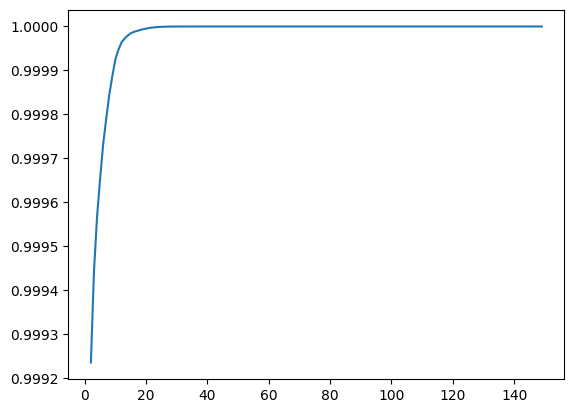

In [89]:
# plotting variance ratio
pd.Series(var_ratio).plot()


<Figure size 500x500 with 0 Axes>

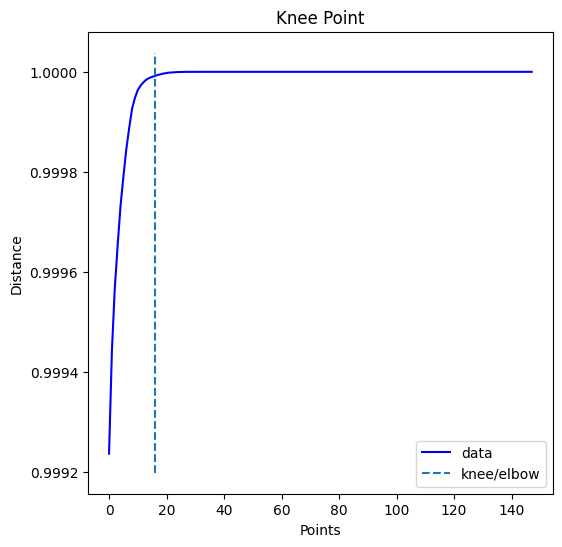

Knee Locator k = 18


In [90]:
#Kneed algorithm to find the elbow point
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)


In [91]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced=pca_final.fit_transform(X_pca)

In [92]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [93]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9986
- F1 score: 0.9986
- Precision: 1.0000
- Recall: 0.9972
- Roc Auc Score: 0.9986
- COST: 39500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9805
- F1 score: 0.9806
- Precision: 0.9735
- Recall: 0.9878
- Roc Auc Score: 0.9806
- COST: 44370.


Decision Tree
Model performance for Training set
- Accuracy: 0.9986
- F1 score: 0.9986
- Precision: 1.0000
- Recall: 0.9972
- Roc Auc Score: 0.9986
- COST: 39500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9726
- F1 score: 0.9727
- Precision: 0.9655
- Recall: 0.9800
- Roc Auc Score: 0.9726
- COST: 71940.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9432
- F1 score: 0.9431
- Precision: 0.9453
- Recall: 0.9409
- Roc Auc Score: 0.9432
- COST: 842240.
----------------------------------
Model performance for Test set
- Accuracy: 0.9373
- F1 score: 0.9372
- Precision: 0.9353
- Recall: 0.9391
-

Report for PCA and Mean imputed data

In [94]:
report_pca

,Model Name,Cost
0,Random Forest,44370
5,XGBClassifier,64300
1,Decision Tree,71940
6,CatBoosting Classifier,79000
4,K-Neighbors Classifier,88090
2,Gradient Boosting,216520
7,AdaBoost Classifier,295880
3,Logistic Regression,697680


Final Model


In [95]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer-Constant","2950"])
pt.add_row(["XGBClassifier","Mice","3510"])
pt.add_row(["XGBClassifier","Knn-Imputer","4470"])
pt.add_row(["XGBClassifier","Simple Imputer-Mean","2380"])
pt.add_row(["CatBoostClassifier","Median","5760"])
pt.add_row(["Random Forest","PCA","44370"])
print(pt)

+--------------------+-------------------------+------------+
|       Model        |    Imputation_method    | Total_cost |
+--------------------+-------------------------+------------+
|   XGBClassifier    | Simple Imputer-Constant |    2950    |
|   XGBClassifier    |           Mice          |    3510    |
|   XGBClassifier    |       Knn-Imputer       |    4470    |
|   XGBClassifier    |   Simple Imputer-Mean   |    2380    |
| CatBoostClassifier |          Median         |    5760    |
|   Random Forest    |           PCA           |   44370    |
+--------------------+-------------------------+------------+


Fitting the Final model and get reports

In [96]:
final_model = XGBClassifier()

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean, y)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [98]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", metrics.accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 0.9999821810406272
Final XGBoost Classifier Accuracy Score (Test) : 0.9970064148253742


In [99]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 2380


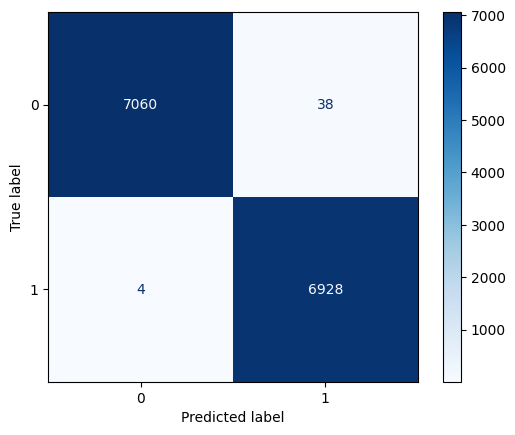

In [100]:
from sklearn.metrics import plot_confusion_matrix

#plots Confusion matrix
plot_confusion_matrix(final_model, X_test, y_test, cmap='Blues', values_format='d')

The best Model is XGBoost Classifier with 99.7% accuracy and cost of 2830


In [1]:
import os

In [4]:
print(os.path.join("sensor","config", "schema.yaml"))

sensor\config\schema.yaml


In [3]:
print(os.getcwd())

d:\Pranay_Laptop_BackUp\PycharmProjects\Test-Project1\Test-1\notebooks
